In [1]:
import pandas as pd
import numpy as np
import json
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ======= Check if CUDA is available =======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ======= Set random seeds for reproducibility =======
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# ======= Model hyperparameters =======
num_words = 10000
maxlen = 100
num_epochs = 10
batch_size = 64
embedding_dim = 256
hidden_dim = 1024
output_dim = 1
n_layers = 2
dropout = 0.2

# ======= Data Loading and Preprocessing =======
def load_data(file_path):
    """Load JSON lines data for sarcasm detection"""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

file_path = "DeteksiSarkasme.json"

data = load_data(file_path)
print(f"Loaded {len(data)} examples from {file_path}\n")

# Display some statistics
print(f"Data Distribution:")
print(data['is_sarcastic'].value_counts())
print("\nExample sarcastic headline:")
print(data[data['is_sarcastic'] == 1]['headline'].iloc[0])
print("\nExample non-sarcastic headline:")
print(data[data['is_sarcastic'] == 0]['headline'].iloc[0])

# ======= Text Preprocessing =======
def preprocess_text(text):
    """Clean and normalize text data"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing to headlines
data['processed_headline'] = data['headline'].apply(preprocess_text)

# ======= Text Tokenization =======
def build_vocabulary(texts, max_words=num_words):
    """Build vocabulary from list of texts"""
    word_counts = {}
    for text in texts:
        for word in text.split():
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
    
    # Sort words by frequency (descending)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Create vocabulary with indices (reserve 0 for padding)
    vocabulary = {'<PAD>': 0, '<UNK>': 1}
    for i, (word, _) in enumerate(sorted_words[:max_words-2]):
        vocabulary[word] = i + 2
    
    return vocabulary

def text_to_sequence(text, vocabulary, maxlen):
    """Convert text to sequence of word indices with padding"""
    sequence = []
    for word in text.split():
        if word in vocabulary:
            sequence.append(vocabulary[word])
        else:
            sequence.append(vocabulary['<UNK>'])
    
    # Pad or truncate to fixed length
    if len(sequence) < maxlen:
        sequence = sequence + [vocabulary['<PAD>']] * (maxlen - len(sequence))
    else:
        sequence = sequence[:maxlen]
    
    return sequence

# Build vocabulary from training data
vocabulary = build_vocabulary(data['processed_headline'])
print(f"\nVocabulary size: {len(vocabulary)}")

# Convert headlines to sequences
data['sequence'] = data['processed_headline'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen))

# Split into train and test sets
X = np.array(data['sequence'].tolist())
y = np.array(data['is_sarcastic'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# ======= Dataset and DataLoader =======
class SarcasmDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create datasets
train_dataset = SarcasmDataset(X_train, y_train)
test_dataset = SarcasmDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Loaded 26709 examples from DeteksiSarkasme.json

Data Distribution:
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

Example sarcastic headline:
mom starting to fear son's web series closest thing she will have to grandchild

Example non-sarcastic headline:
former versace store clerk sues over secret 'black code' for minority shoppers

Vocabulary size: 10000
Training set size: 21367
Test set size: 5342


# RNN Model

In [3]:
# ======= RNN Model =======
class RNN_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.RNN = nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
            bidirectional=False
        )
        self.attention = nn.Linear(hidden_dim, 1)  # Attention mechanism
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        # text shape: [batch_size, seq_len]
        embedded = self.embedding(text)
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        output, (hidden, cell) = self.RNN(embedded)
        # output shape: [batch_size, seq_len, hidden_dim]
        
        # Attention mechanism
        attn_weights = torch.softmax(self.attention(output), dim=1)
        # attn_weights shape: [batch_size, seq_len, 1]
        
        # Compute context vector as a weighted sum of RNN outputs
        context_vector = torch.sum(attn_weights * output, dim=1)
        # context_vector shape: [batch_size, hidden_dim]
        
        # Apply dropout
        context_vector = self.dropout(context_vector)
        
        # Fully connected layer
        out = self.fc(context_vector)
        # Output shape: [batch_size, output_dim]
        return out.squeeze(-1)  # Squeeze to ensure shape consistency


vocab_size = len(vocabulary)

# Initialize model
model = RNN_Model(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model = model.to(device)

# ======= Training =======
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backpropagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Accumulate loss
        epoch_train_loss += loss.item() * inputs.size(0)
        
        # Calculate accuracy
        predicted = (outputs >= 0.5).float()
        epoch_train_correct += (predicted == labels).sum().item()
        epoch_train_total += labels.size(0)
    
    # Calculate epoch training metrics
    epoch_train_loss = epoch_train_loss / len(train_dataset)
    epoch_train_acc = epoch_train_correct / epoch_train_total
    
    # Validation
    model.eval()
    epoch_val_loss = 0
    epoch_val_correct = 0
    epoch_val_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Accumulate loss
            epoch_val_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            predicted = (outputs >= 0.5).float()
            epoch_val_correct += (predicted == labels).sum().item()
            epoch_val_total += labels.size(0)
    
    # Calculate epoch validation metrics
    epoch_val_loss = epoch_val_loss / len(test_dataset)
    epoch_val_acc = epoch_val_correct / epoch_val_total
    
    # Store metrics for plotting
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1}: Train Accuracy={epoch_train_acc:.4f}, Test Accuracy={epoch_val_acc:.4f} | Train Loss={epoch_train_loss:.4f}, Test Loss={epoch_val_loss:.4f}")

Epoch 1: Train Accuracy=0.6771, Test Accuracy=0.7404 | Train Loss=0.5548, Test Loss=0.5051
Epoch 2: Train Accuracy=0.7445, Test Accuracy=0.7508 | Train Loss=0.4846, Test Loss=0.4804
Epoch 3: Train Accuracy=0.7769, Test Accuracy=0.7707 | Train Loss=0.4399, Test Loss=0.4669
Epoch 4: Train Accuracy=0.7980, Test Accuracy=0.7763 | Train Loss=0.4048, Test Loss=0.4761
Epoch 5: Train Accuracy=0.8208, Test Accuracy=0.7589 | Train Loss=0.3717, Test Loss=0.4765
Epoch 6: Train Accuracy=0.8344, Test Accuracy=0.7774 | Train Loss=0.3444, Test Loss=0.5061
Epoch 7: Train Accuracy=0.8581, Test Accuracy=0.7726 | Train Loss=0.3143, Test Loss=0.5069
Epoch 8: Train Accuracy=0.8722, Test Accuracy=0.7757 | Train Loss=0.2865, Test Loss=0.5310
Epoch 9: Train Accuracy=0.8843, Test Accuracy=0.7617 | Train Loss=0.2611, Test Loss=0.5621
Epoch 10: Train Accuracy=0.9004, Test Accuracy=0.7731 | Train Loss=0.2313, Test Loss=0.5859



Final Evaluation on Test Set:
Accuracy : 0.7731
Precision: 0.7896
Recall   : 0.6590
F1 Score : 0.7184
AUC      : 0.8514


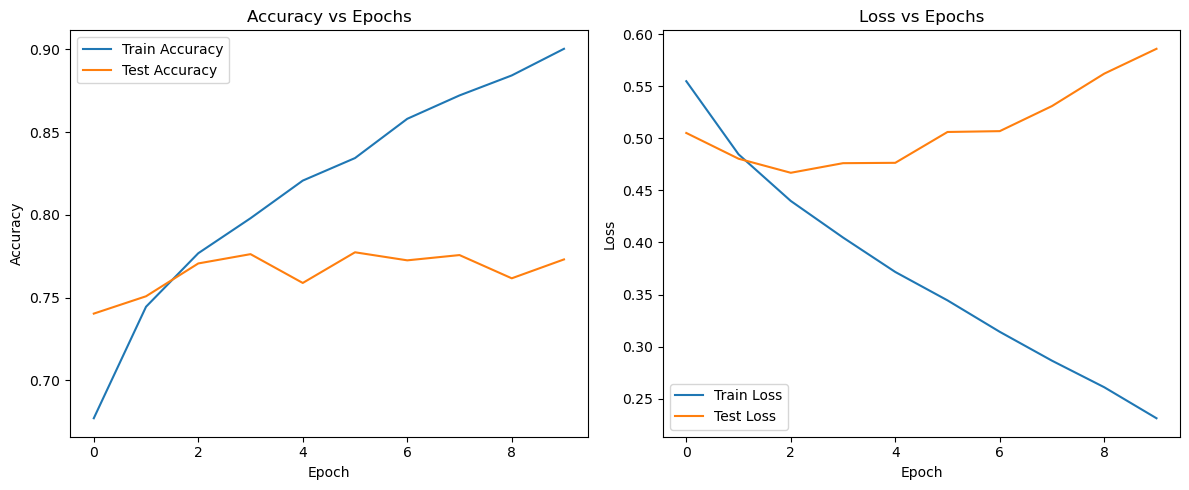

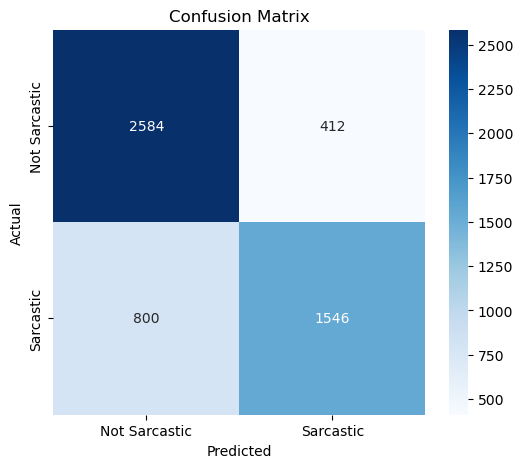

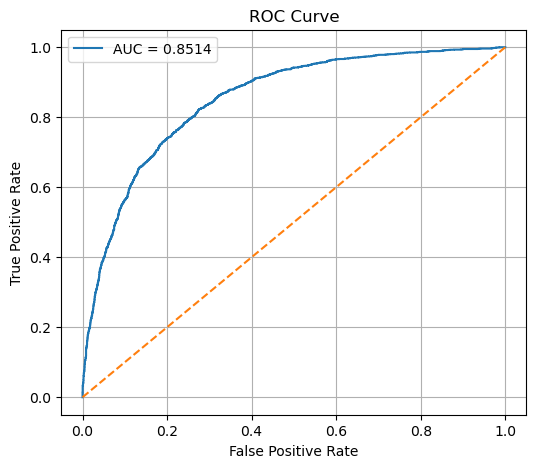

In [4]:
# ======= Final Evaluation =======
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
binary_preds = (all_preds >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(all_labels, binary_preds)
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, binary_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Function to make predictions on new text
def predict_sarcasm(model, text, vocabulary, maxlen, device):
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Convert text to sequence
    sequence = text_to_sequence(processed_text, vocabulary, maxlen)
    sequence = torch.tensor(sequence, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Forward pass
        logits = model(sequence)
        probability = torch.sigmoid(logits).item()  # Apply sigmoid to get probability
    
    # Determine sarcasm based on threshold (0.5)
    is_sarcastic = probability >= 0.5
    
    return is_sarcastic, probability

# ======= Example Usage =======
example_text = "This is absolutely the best day of my life!"
is_sarcastic, prob = predict_sarcasm(model, example_text, vocabulary, maxlen, device)

print(f"Input: {example_text}")
print(f"Is Sarcastic: {is_sarcastic}")
print(f"Probability of Sarcasm: {prob:.4f}")

Input: This is absolutely the best day of my life!
Is Sarcastic: False
Probability of Sarcasm: 0.0157


# LSTM Model

In [6]:
# ======= LSTM Model =======
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.LSTM = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
            bidirectional=False
        )
        self.attention = nn.Linear(hidden_dim, 1)  # Attention mechanism
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        # text shape: [batch_size, seq_len]
        embedded = self.embedding(text)
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        output, (hidden, cell) = self.LSTM(embedded)
        # output shape: [batch_size, seq_len, hidden_dim]
        
        # Attention mechanism
        attn_weights = torch.softmax(self.attention(output), dim=1)
        # attn_weights shape: [batch_size, seq_len, 1]
        
        # Compute context vector as a weighted sum of LSTM outputs
        context_vector = torch.sum(attn_weights * output, dim=1)
        # context_vector shape: [batch_size, hidden_dim]
        
        # Apply dropout
        context_vector = self.dropout(context_vector)
        
        # Fully connected layer
        out = self.fc(context_vector)
        # Output shape: [batch_size, output_dim]
        return out.squeeze(-1)  # Squeeze to ensure shape consistency


vocab_size = len(vocabulary)

# Initialize model
model = LSTM_Model(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model = model.to(device)

# ======= Training =======
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backpropagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Accumulate loss
        epoch_train_loss += loss.item() * inputs.size(0)
        
        # Calculate accuracy
        predicted = (outputs >= 0.5).float()
        epoch_train_correct += (predicted == labels).sum().item()
        epoch_train_total += labels.size(0)
    
    # Calculate epoch training metrics
    epoch_train_loss = epoch_train_loss / len(train_dataset)
    epoch_train_acc = epoch_train_correct / epoch_train_total
    
    # Validation
    model.eval()
    epoch_val_loss = 0
    epoch_val_correct = 0
    epoch_val_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Accumulate loss
            epoch_val_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            predicted = (outputs >= 0.5).float()
            epoch_val_correct += (predicted == labels).sum().item()
            epoch_val_total += labels.size(0)
    
    # Calculate epoch validation metrics
    epoch_val_loss = epoch_val_loss / len(test_dataset)
    epoch_val_acc = epoch_val_correct / epoch_val_total
    
    # Store metrics for plotting
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1}: Train Accuracy={epoch_train_acc:.4f}, Test Accuracy={epoch_val_acc:.4f} | Train Loss={epoch_train_loss:.4f}, Test Loss={epoch_val_loss:.4f}")

Epoch 1: Train Accuracy=0.6834, Test Accuracy=0.7450 | Train Loss=0.5522, Test Loss=0.5031
Epoch 2: Train Accuracy=0.7665, Test Accuracy=0.7767 | Train Loss=0.4562, Test Loss=0.4641
Epoch 3: Train Accuracy=0.8116, Test Accuracy=0.7984 | Train Loss=0.3900, Test Loss=0.4253
Epoch 4: Train Accuracy=0.8505, Test Accuracy=0.8102 | Train Loss=0.3245, Test Loss=0.3894
Epoch 5: Train Accuracy=0.8811, Test Accuracy=0.8233 | Train Loss=0.2714, Test Loss=0.4148
Epoch 6: Train Accuracy=0.9080, Test Accuracy=0.8349 | Train Loss=0.2193, Test Loss=0.3819
Epoch 7: Train Accuracy=0.9286, Test Accuracy=0.8360 | Train Loss=0.1771, Test Loss=0.4022
Epoch 8: Train Accuracy=0.9443, Test Accuracy=0.8358 | Train Loss=0.1473, Test Loss=0.4615
Epoch 9: Train Accuracy=0.9601, Test Accuracy=0.8311 | Train Loss=0.1101, Test Loss=0.5043
Epoch 10: Train Accuracy=0.9687, Test Accuracy=0.8338 | Train Loss=0.0882, Test Loss=0.5898



Final Evaluation on Test Set:
Accuracy : 0.8338
Precision: 0.8407
Recall   : 0.7668
F1 Score : 0.8021
AUC      : 0.9095


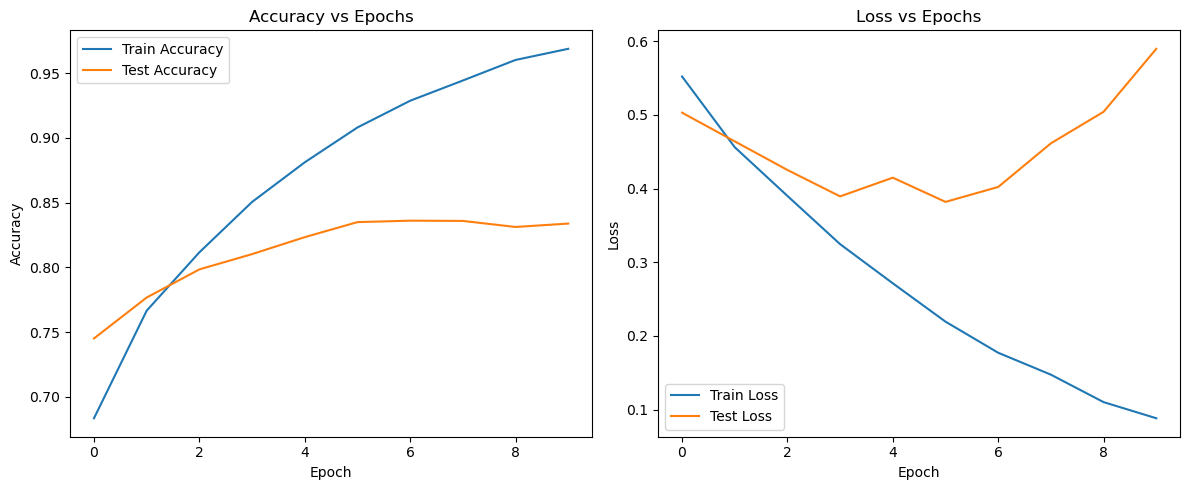

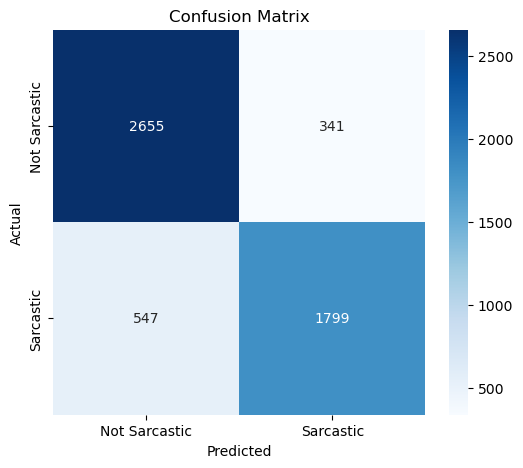

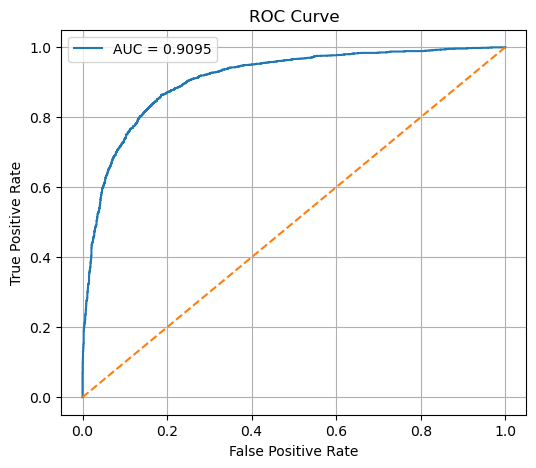

In [7]:
# ======= Final Evaluation =======
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
binary_preds = (all_preds >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(all_labels, binary_preds)
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, binary_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Function to make predictions on new text
def predict_sarcasm(model, text, vocabulary, maxlen, device):
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Convert text to sequence
    sequence = text_to_sequence(processed_text, vocabulary, maxlen)
    sequence = torch.tensor(sequence, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Forward pass
        logits = model(sequence)
        probability = torch.sigmoid(logits).item()  # Apply sigmoid to get probability
    
    # Determine sarcasm based on threshold (0.5)
    is_sarcastic = probability >= 0.5
    
    return is_sarcastic, probability

# ======= Example Usage =======
example_text = "This is absolutely the best day of my life!"
is_sarcastic, prob = predict_sarcasm(model, example_text, vocabulary, maxlen, device)

print(f"Input: {example_text}")
print(f"Is Sarcastic: {is_sarcastic}")
print(f"Probability of Sarcasm: {prob:.4f}")

Input: This is absolutely the best day of my life!
Is Sarcastic: False
Probability of Sarcasm: 0.0064


# GRU Model

In [9]:
# ======= GRU Model =======
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.GRU = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
            bidirectional=False
        )
        self.attention = nn.Linear(hidden_dim, 1)  # Attention mechanism
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        # text shape: [batch_size, seq_len]
        embedded = self.embedding(text)
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        output, (hidden, cell) = self.GRU(embedded)
        # output shape: [batch_size, seq_len, hidden_dim]
        
        # Attention mechanism
        attn_weights = torch.softmax(self.attention(output), dim=1)
        # attn_weights shape: [batch_size, seq_len, 1]
        
        # Compute context vector as a weighted sum of GRU outputs
        context_vector = torch.sum(attn_weights * output, dim=1)
        # context_vector shape: [batch_size, hidden_dim]
        
        # Apply dropout
        context_vector = self.dropout(context_vector)
        
        # Fully connected layer
        out = self.fc(context_vector)
        # Output shape: [batch_size, output_dim]
        return out.squeeze(-1)  # Squeeze to ensure shape consistency


vocab_size = len(vocabulary)

# Initialize model
model = GRU_Model(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model = model.to(device)

# ======= Training =======
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backpropagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Accumulate loss
        epoch_train_loss += loss.item() * inputs.size(0)
        
        # Calculate accuracy
        predicted = (outputs >= 0.5).float()
        epoch_train_correct += (predicted == labels).sum().item()
        epoch_train_total += labels.size(0)
    
    # Calculate epoch training metrics
    epoch_train_loss = epoch_train_loss / len(train_dataset)
    epoch_train_acc = epoch_train_correct / epoch_train_total
    
    # Validation
    model.eval()
    epoch_val_loss = 0
    epoch_val_correct = 0
    epoch_val_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Accumulate loss
            epoch_val_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            predicted = (outputs >= 0.5).float()
            epoch_val_correct += (predicted == labels).sum().item()
            epoch_val_total += labels.size(0)
    
    # Calculate epoch validation metrics
    epoch_val_loss = epoch_val_loss / len(test_dataset)
    epoch_val_acc = epoch_val_correct / epoch_val_total
    
    # Store metrics for plotting
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1}: Train Accuracy={epoch_train_acc:.4f}, Test Accuracy={epoch_val_acc:.4f} | Train Loss={epoch_train_loss:.4f}, Test Loss={epoch_val_loss:.4f}")

Epoch 1: Train Accuracy=0.6878, Test Accuracy=0.7228 | Train Loss=0.5448, Test Loss=0.4956
Epoch 2: Train Accuracy=0.7644, Test Accuracy=0.7679 | Train Loss=0.4556, Test Loss=0.4492
Epoch 3: Train Accuracy=0.8053, Test Accuracy=0.7956 | Train Loss=0.3970, Test Loss=0.4153
Epoch 4: Train Accuracy=0.8381, Test Accuracy=0.8049 | Train Loss=0.3418, Test Loss=0.4123
Epoch 5: Train Accuracy=0.8672, Test Accuracy=0.8182 | Train Loss=0.2912, Test Loss=0.3865
Epoch 6: Train Accuracy=0.8932, Test Accuracy=0.8295 | Train Loss=0.2429, Test Loss=0.4244
Epoch 7: Train Accuracy=0.9155, Test Accuracy=0.8317 | Train Loss=0.1996, Test Loss=0.4284
Epoch 8: Train Accuracy=0.9341, Test Accuracy=0.8289 | Train Loss=0.1582, Test Loss=0.4523
Epoch 9: Train Accuracy=0.9504, Test Accuracy=0.8227 | Train Loss=0.1262, Test Loss=0.4871
Epoch 10: Train Accuracy=0.9605, Test Accuracy=0.8311 | Train Loss=0.1009, Test Loss=0.5649



Final Evaluation on Test Set:
Accuracy : 0.8311
Precision: 0.8333
Recall   : 0.7694
F1 Score : 0.8001
AUC      : 0.9088


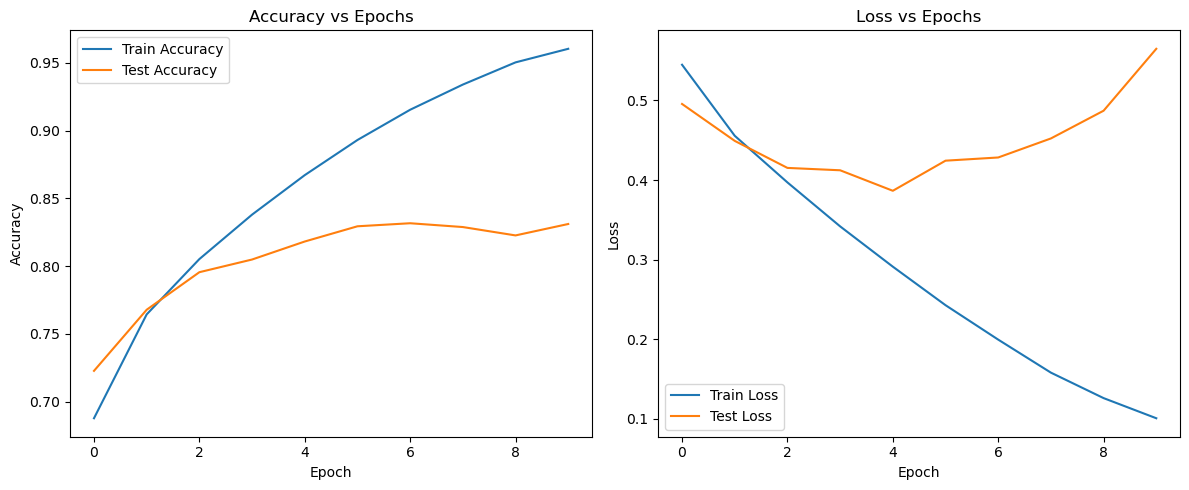

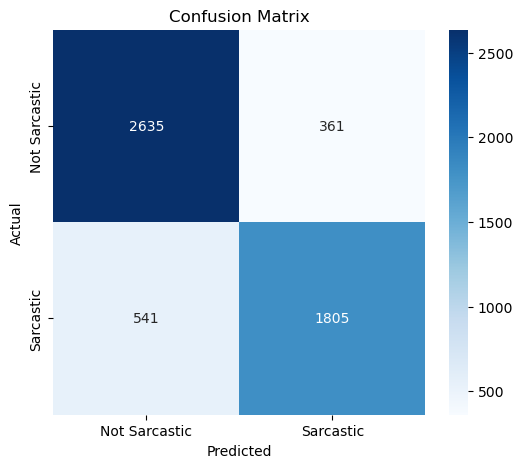

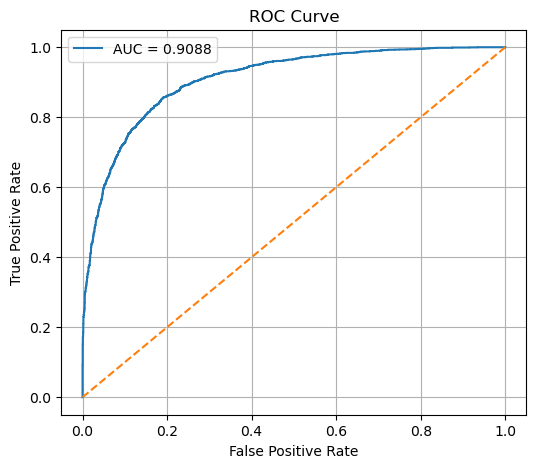

In [10]:
# ======= Final Evaluation =======
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
binary_preds = (all_preds >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(all_labels, binary_preds)
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, binary_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Function to make predictions on new text
def predict_sarcasm(model, text, vocabulary, maxlen, device):
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Convert text to sequence
    sequence = text_to_sequence(processed_text, vocabulary, maxlen)
    sequence = torch.tensor(sequence, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Forward pass
        logits = model(sequence)
        probability = torch.sigmoid(logits).item()  # Apply sigmoid to get probability
    
    # Determine sarcasm based on threshold (0.5)
    is_sarcastic = probability >= 0.5
    
    return is_sarcastic, probability

# ======= Example Usage =======
example_text = "This is absolutely the best day of my life!"
is_sarcastic, prob = predict_sarcasm(model, example_text, vocabulary, maxlen, device)

print(f"Input: {example_text}")
print(f"Is Sarcastic: {is_sarcastic}")
print(f"Probability of Sarcasm: {prob:.4f}")

Input: This is absolutely the best day of my life!
Is Sarcastic: False
Probability of Sarcasm: 0.0020


# Penjelasan Model, Visualisasi, dan Metrik

## 1. RNN (Recurrent Neural Network)

RNN menggunakan mekanisme **recurrence** untuk mengolah data urut seperti teks atau waktu. Formula utama yang digunakan dalam RNN adalah:

### Persamaan Dasar:
- **State Update**:
  $$
  h_t = f(W_h \cdot h_{t-1} + W_x \cdot x_t + b)
  $$
  - **Penjelasan**:
    - \($h_t$\): State tersembunyi pada waktu \(t\).
    - \($x_t$\): Input saat waktu \(t\).
    - \($W_h$\), \($W_x$\): Matriks bobot untuk state sebelumnya dan input saat ini.
    - \($b$\): Bias.
    - \($f$\): Fungsi aktivasi (contoh: tanh atau ReLU).

### Alur:
Pada setiap langkah waktu, RNN memperbarui state tersembunyi \($h_t$\) menggunakan input saat itu \($x_t$\) dan state sebelumnya \($h_{t-1}$\).

---

## 2. LSTM (Long Short-Term Memory)

LSTM mengatasi masalah **vanishing gradient** yang sering dialami RNN dengan menggunakan **gate mechanism**.

### Persamaan Dasar:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $$
   - **Fungsi**: Memutuskan informasi mana yang harus dibuang dari memori.

2. **Input Gate**:
   $$
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1}, x_t] + b_C)
   $$
   - **Fungsi**: Menghitung memori baru yang akan ditambahkan.

3. **Cell State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   - **Fungsi**: Memperbarui state sel.

4. **Output Gate**:
   $$
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$
   - **Fungsi**: Menghitung keluaran berdasarkan state sel yang diperbarui.

---

## 3. GRU (Gated Recurrent Unit)

GRU adalah versi sederhana dari LSTM tanpa cell state terpisah. Persamaan yang digunakan:

### Persamaan Dasar:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
   $$
   - **Fungsi**: Memutuskan informasi masa lalu yang harus dilupakan.

2. **Update Gate**:
   $$
   z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
   $$
   - **Fungsi**: Mengontrol berapa banyak informasi dari masa lalu yang akan dibawa ke state saat ini.

3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$
   - **Fungsi**: State tersembunyi diperbarui menggunakan reset dan update gate.

---

## 4. Visualisasi

### Akurasi:
Akurasi dihitung sebagai:
$$
\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Sampel}}
$$

### Loss:
Loss dalam pelatihan model dihitung menggunakan fungsi **Binary Cross Entropy (BCE)**:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya.
- \($\hat{y}_i$\): Probabilitas prediksi model.

### ROC Curve:
ROC Curve menunjukkan hubungan antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**:
- **TPR**:
  $$
  TPR = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$
- **FPR**:
  $$
  FPR = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
  $$

### AUC (Area Under Curve):
AUC mengukur area di bawah ROC Curve:
$$
\text{AUC} = \int_{0}^{1} TPR(FPR) \,dFPR
$$
Nilai AUC berkisar antara 0 hingga 1, dengan 1 menunjukkan prediksi sempurna.

---

## 5. Metrik

### Precision:
Precision mengukur seberapa tepat model dalam prediksi kelas positif:
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

### Recall:
Recall mengukur kemampuan model untuk mendeteksi semua kelas positif:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

### F1 Score:
F1 Score adalah rata-rata harmonis antara precision dan recall:
$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

# Penjelasan Matematika PyTorch

## 1. Embedding Layer
Layer **`nn.Embedding`** digunakan untuk mengubah input indeks menjadi representasi vektor yang dapat dipelajari:
$$
E(x_t) = W_{embedding} \cdot x_t
$$
- **Dimensi**:
  - \($x_t$\): Input berupa indeks kata, dengan dimensi \($(batch\_size, sequence\_length)$\).
  - \($W_{embedding}$\): Matriks bobot dengan ukuran \($(\text{vocab\_size}, \text{embed\_dim})$\).
  - Output: Tensor dengan dimensi \($(batch\_size, sequence\_length, \text{embed\_dim})$\).

PyTorch secara otomatis memperbarui \($W_{embedding}$\) selama pelatihan untuk menghasilkan representasi kata yang bermakna.

---

## 2. RNN, GRU, dan LSTM
### **a. RNN (`nn.RNN`)**
Recurrent Neural Network (RNN) digunakan untuk memproses data sekuensial. Persamaan matematisnya adalah:
$$
h_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
$$
- \($h_t$\): State tersembunyi pada waktu \($t$\).
- \($W_{ih}$\): Bobot input ke hidden state (\($\text{input\_dim}$ $\to$ $\text{hidden\_dim}$\)).
- \($W_{hh}$\): Bobot antara hidden state (\($\text{hidden\_dim}$ $\to$ $\text{hidden\_dim}$\)).
- \($b_h$\): Bias.
- Fungsi aktivasi: **tanh**.

Output RNN adalah state tersembunyi pada setiap langkah waktu.

---

### **b. GRU (`nn.GRU`)**
GRU menggunakan mekanisme gate untuk menangani vanishing gradient:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_{ir} \cdot x_t + W_{hr} \cdot h_{t-1} + b_r)
   $$
   - Mengontrol seberapa banyak informasi masa lalu yang dilupakan.
2. **Update Gate**:
   $$
   z_t = \sigma(W_{iz} \cdot x_t + W_{hz} \cdot h_{t-1} + b_z)
   $$
   - Mengontrol informasi baru yang ditambahkan ke state.
3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot (r_t \odot h_{t-1}) + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$

PyTorch menangani semua kalkulasi ini secara otomatis dalam layer GRU.

---

### **c. LSTM (`nn.LSTM`)**
LSTM memiliki struktur yang lebih kompleks dibanding GRU, dengan 3 jenis gate:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_{if} \cdot x_t + W_{hf} \cdot h_{t-1} + b_f)
   $$
2. **Input Gate**:
   $$
   i_t = \sigma(W_{ii} \cdot x_t + W_{hi} \cdot h_{t-1} + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_{ic} \cdot x_t + W_{hc} \cdot h_{t-1} + b_c)
   $$
3. **Output Gate**:
   $$
   o_t = \sigma(W_{io} \cdot x_t + W_{ho} \cdot h_{t-1} + b_o)
   $$
4. **State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$

Di PyTorch, `nn.LSTM` mengelola kedua state (\($h_t$\), \($C_t$\)) secara otomatis.

---

## 3. Dropout (`nn.Dropout`)
Layer `nn.Dropout` digunakan untuk regularisasi. Operasinya dapat dirumuskan sebagai:
$$
d_t = M \cdot h_t
$$
- \($M$\): Mask binari yang dihasilkan dengan probabilitas \($p$\) untuk dropout.

Dropout diaktifkan selama pelatihan (`model.train()`) tetapi tidak diterapkan saat evaluasi (`model.eval()`).

---

## 4. Fully Connected Layers (`nn.Linear`)
Layer `nn.Linear` adalah transformasi linier sederhana:
$$
y_t = W \cdot h_t + b
$$
- \($W$\): Matriks bobot (\($\text{hidden\_dim} \to \text{output\_dim}$\)).
- \($b$\): Bias.

Fungsi aktivasi seperti `ReLU` atau `Sigmoid` diterapkan setelah `nn.Linear` untuk menambahkan non-linearitas.

---

## 5. Binary Cross-Entropy Loss (BCELoss)
Loss dihitung menggunakan rumus:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya (0 atau 1).
- \($\hat{y}_i$\): Probabilitas prediksi setelah fungsi sigmoid.

---

## 6. GradScaler
PyTorch mendukung precision campuran dengan `torch.amp.GradScaler` untuk mencegah angka terlalu kecil atau besar:
- **Forward Pass**:
  $$ \text{loss} = \text{criterion}(output, label) $$
- **Gradient Scaling**:
  $$ \text{scaled\_loss} = \text{scale} \cdot \text{loss} $$
- Setelah backward pass:
  $$ \text{gradients} = \frac{\partial (\text{scaled\_loss})}{\partial (\text{parameters})} $$

Scaler memperbarui bobot sambil mempertahankan stabilitas numerik.

---

## 7. ReduceLROnPlateau
Scheduler ini mengurangi learning rate berdasarkan stagnasi pada loss validasi:
$$
\text{lr\_new} = \text{lr\_old} \times \text{factor}
$$
Dengan **PyTorch**:
```python
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)
scheduler.step(test_loss)
